In [5]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import numpy as np
import random
import imageio
import PIL, cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image, ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
import seaborn as sns
from sklearn.metrics import roc_curve, auc

C:\Users\Amira\AppData\Local\Temp\ipykernel_18872\2593690578.py:24: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


# Data loading and preprocessing

In [4]:
# Function to extract labels from image filenames
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    print(subject_id, etc)
    print("filename: ", filename)
    
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')
    
    gender = 0 if gender == 'M' else 1
    lr = 0 if lr == 'Left' else 1
    
    if finger == 'thumb':
        finger = 0
    elif finger == 'index':
        finger = 1
    elif finger == 'middle':
        finger = 2
    elif finger == 'ring':
        finger = 3
    elif finger == 'little':
        finger = 4
     
    return np.array([finger], dtype=np.uint16)

In [5]:
IMG_SIZE = 96

def load_data(path, train):
    print("loading data from: ", path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    return data

In [6]:

Real_path = r"D:\PRpro\SOCOFing\Real"
Easy_path = r"D:\PRpro\SOCOFing\Altered\Altered-Easy"
Medium_path = r"D:\PRpro\SOCOFing\Altered\Altered-Medium"
Hard_path = r"D:\PRpro\SOCOFing\Altered\Altered-Hard"

In [7]:
easy_data = load_data(Easy_path, train=True)
medium_data = load_data(Medium_path, train=True)
hard_data = load_data(Hard_path, train=True)
test = load_data(Real_path, train=False)

loading data from:  D:\College\Term 8\Freelancing\Sokoto Coventry Fingerprint Dataset (SOCOFing)\SOCOFing\SOCOFing\Altered\Altered-Easy
100 M_Left_index_finger_CR
filename:  100__M_Left_index_finger_CR
100 M_Left_index_finger_Obl
filename:  100__M_Left_index_finger_Obl
100 M_Left_index_finger_Zcut
filename:  100__M_Left_index_finger_Zcut
100 M_Left_little_finger_CR
filename:  100__M_Left_little_finger_CR
100 M_Left_little_finger_Obl
filename:  100__M_Left_little_finger_Obl
100 M_Left_little_finger_Zcut
filename:  100__M_Left_little_finger_Zcut
100 M_Left_middle_finger_CR
filename:  100__M_Left_middle_finger_CR
100 M_Left_middle_finger_Obl
filename:  100__M_Left_middle_finger_Obl
100 M_Left_middle_finger_Zcut
filename:  100__M_Left_middle_finger_Zcut
100 M_Left_ring_finger_CR
filename:  100__M_Left_ring_finger_CR
100 M_Left_ring_finger_Obl
filename:  100__M_Left_ring_finger_Obl
100 M_Left_ring_finger_Zcut
filename:  100__M_Left_ring_finger_Zcut
100 M_Left_thumb_finger_CR
filename:  100_

In [8]:
import random

# Shuffle each dataset individually
random.shuffle(easy_data)
random.shuffle(medium_data)
random.shuffle(hard_data)

# Combine all datasets 
data = easy_data + medium_data + hard_data

# Shuffle the combined dataset
random.shuffle(data)


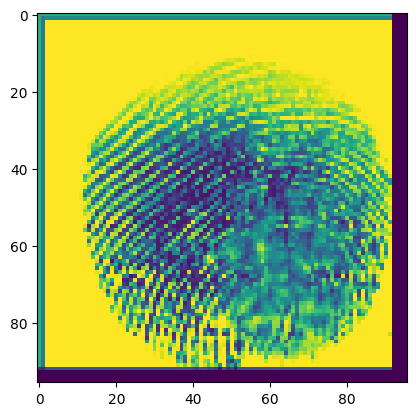

In [10]:
import matplotlib.pyplot as plt

plt.imshow(easy_data[0][1])

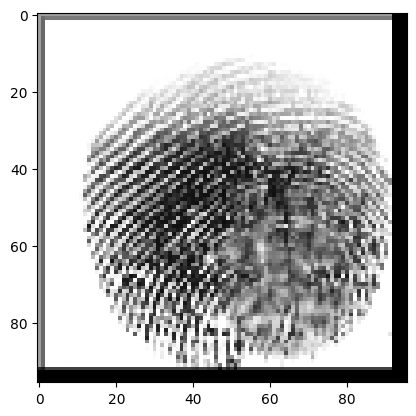

In [11]:
# display gray scale 
plt.imshow(easy_data[0][1], cmap='gray')


# Minutiae extraction

In [79]:
def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);
    
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;
    
    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))         
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [80]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block);
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
        return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)
    
    WindowSize = 2          
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1 
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));
        
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

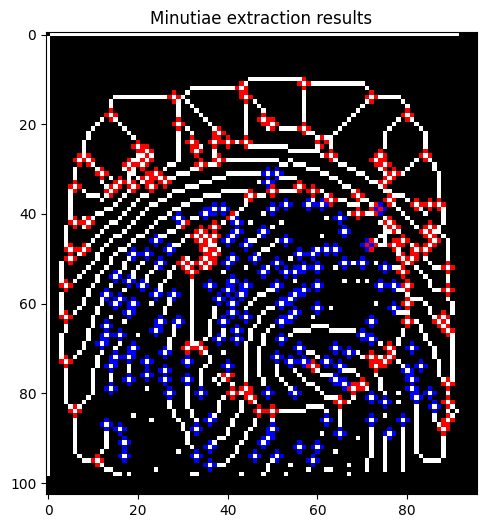

In [92]:
img_name = r"D:\PRpro\SOCOFing\Altered\Altered-Medium\1__M_Left_index_finger_CR.BMP"

img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
THRESHOLD1 = img.mean() 
img = np.array(img > THRESHOLD1).astype(int)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255;
mask = img*255;

(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask);
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=1);
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1);
ShowResults(skel, TermLabel, BifLabel)

In [12]:
X, y = [],[]

for label, feature in data:
    y.append(label)
    X.append(feature)

 
X_train = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_train = X_train/255

y_train = np.array(y)

In [13]:
X_train.shape, y_train.shape

((49270, 96, 96, 1), (49270,))

In [60]:
# the len and type of data
print("Total number of images: ", len(data))
print("Type of each image: ", type(data[0][1]))
print("Shape of each image: ", data[0][1].shape)


Total number of images:  49270
Type of each image:  <class 'numpy.ndarray'>
Shape of each image:  (96, 96)


In [16]:
# Reshape the input features
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Ensemble Method

(Random Forest Classifier, Gradient Boosting Classifier)

In [18]:
# Ensemble Methods
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=50, random_state=42)

In [19]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gb', gb_clf)], voting='hard')
voting_clf.fit(X_train_flat, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=50,
                                                         random_state=42))])

Saving the model

In [20]:
import pickle

# Specify the file path where you want to save the model
model_file_path = "voting_classifier_model.pkl"

# Save the trained model to disk
with open(model_file_path, 'wb') as model_file:
    pickle.dump(voting_clf, model_file)

print("Model saved successfully.")


Model saved successfully.


In [21]:
X_test,y_test = [],[]

for label, feature in test:
    y_test.append(label)
    X_test.append(feature)
    
X_test = np.array(X_test).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test/255

y_test = np.array(y_test)

In [22]:
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Evaluate Ensemble Method

In [23]:
# Evaluate Ensemble Methods
ensemble_predictions = voting_clf.predict(X_test_flat)
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_predictions)
ensemble_report = classification_report(y_test, ensemble_predictions)

# Print results
print("Ensemble Classifier Results:")
print("Confusion Matrix:")
print(ensemble_conf_matrix)
print("Classification Report:")
print(ensemble_report)

# Get individual estimators from VotingClassifier
estimators = voting_clf.estimators_

# Now, you can evaluate each individual estimator if needed
for estimator in estimators:
    predictions = estimator.predict(X_test_flat)
    # Calculate confusion matrix, classification report, etc.


Ensemble Classifier Results:
Confusion Matrix:
[[1200    0    0    0    0]
 [  59 1140    0    0    1]
 [  70  128 1002    0    0]
 [  55  110   91  944    0]
 [  20   91   43   82  964]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1200
           1       0.78      0.95      0.85      1200
           2       0.88      0.83      0.86      1200
           3       0.92      0.79      0.85      1200
           4       1.00      0.80      0.89      1200

    accuracy                           0.88      6000
   macro avg       0.89      0.88      0.87      6000
weighted avg       0.89      0.88      0.87      6000



Ensemble Classifier Metrics

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Calculate performance metrics for ensemble classifier
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions, average='weighted')
ensemble_recall = recall_score(y_test, ensemble_predictions, average='weighted')
ensemble_f1 = f1_score(y_test, ensemble_predictions, average='weighted')


print("Ensemble Classifier Metrics:")
print("Accuracy:", ensemble_accuracy)
print("Precision:", ensemble_precision)
print("Recall:", ensemble_recall)
print("F1 Score:", ensemble_f1)



Ensemble Classifier Metrics:
Accuracy: 0.875
Precision: 0.8863645865344693
Recall: 0.875
F1 Score: 0.8744955073094147


confusion matrix

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define a function to plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

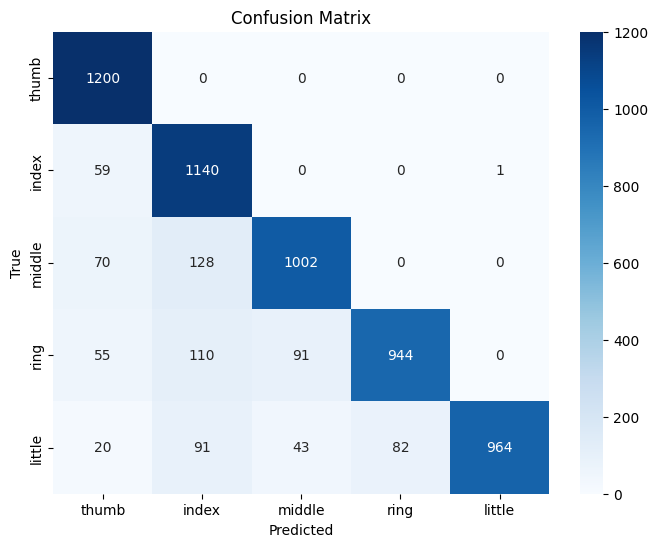

In [31]:

# Calculate confusion matrix for ensemble classifier
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
# Plot confusion matrix for ensemble classifier
plot_confusion_matrix(ensemble_cm, labels=['thumb', 'index', 'middle', 'ring', 'little'])


ROC Curve

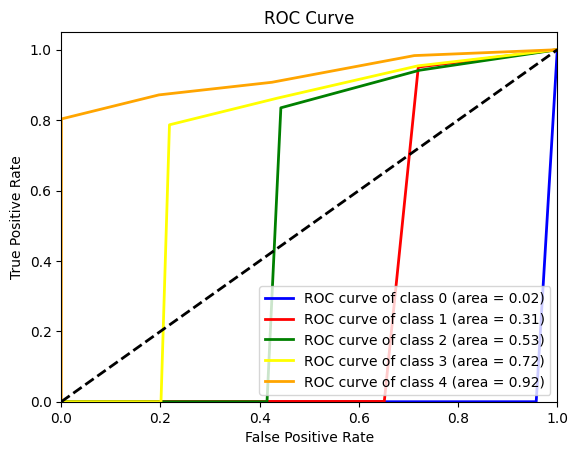

In [77]:
from sklearn.metrics import roc_curve, auc

# Get predicted classes using the voting classifier
ensemble_y_pred_classes = voting_clf.predict(X_test_flat)

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):  # assuming 5 classes
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), ensemble_y_pred_classes)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'yellow', 'orange']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Evaluate DL Model

Load Model

In [1]:
from keras.models import load_model

# Load your saved model
saved_model = load_model(r'D:\PRpro\SOCOFing\fingerprint.h5')

# Evaluate the saved model
saved_model.evaluate(X_test, y_test)

# Predict using the saved model
dl_model_predictions = saved_model.predict(X_test)

In [78]:
y_test = np.array(y_test)
predicted = saved_model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


In [35]:
predicted = [np.argmax(i) for i in dl_model_predictions]
predicted[:5]

[1, 4, 2, 3, 0]

confusion matrix

In [36]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test,predictions=predicted)

Text(50.722222222222214, 0.5, 'Truth')

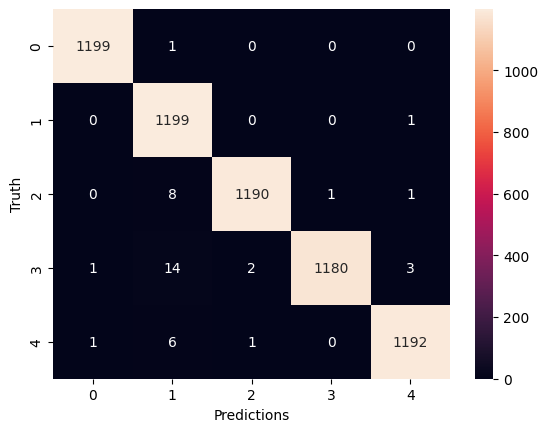

In [37]:
import seaborn as sn

sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel("Predictions")
plt.ylabel("Truth")

DL Classifier Metrics

In [41]:
# Calculate performance metrics for ensemble classifier
dl_accuracy = accuracy_score(y_test, predicted)
dl_precision = precision_score(y_test, predicted, average='weighted')
dl_recall = recall_score(y_test, predicted, average='weighted')
dl_f1 = f1_score(y_test, predicted, average='weighted')
dl_classification_report = classification_report(y_test, predicted)


print("DL Classifier Metrics:")
print("Accuracy:", dl_accuracy)
print("Precision:", dl_precision)
print("Recall:", dl_recall)
print("F1 Score:", dl_f1)


DL Classifier Metrics:
Accuracy: 0.9933333333333333
Precision: 0.9934361134987251
Recall: 0.9933333333333333
F1 Score: 0.9933437782223942


ROC Curve DL

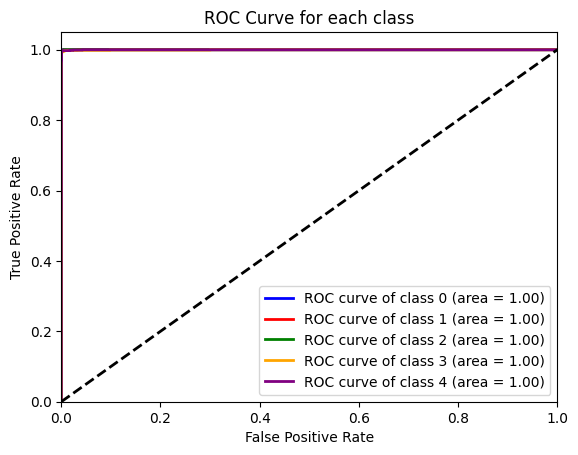

In [76]:
n_classes = 5
# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.show()

# Comparing both models

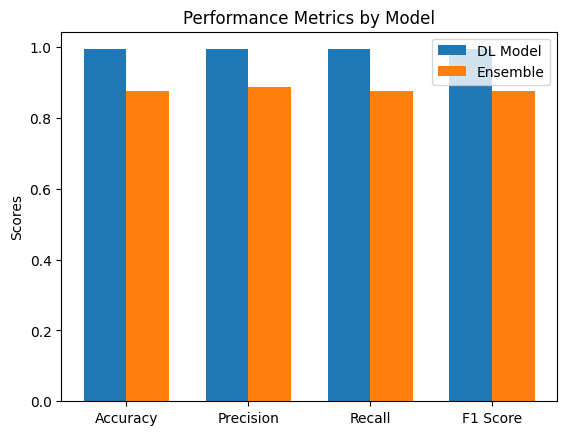

In [40]:
# Create a bar chart for comparative analysis
import matplotlib.pyplot as plt

# Create a bar chart for comparative analysis
labels = ['DL Model', 'Ensemble']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
svm_metrics = [dl_accuracy, dl_precision, dl_recall, dl_f1]
ensemble_metrics = [ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, svm_metrics, width, label='DL Model')
rects2 = ax.bar(x + width/2, ensemble_metrics, width, label='Ensemble')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


# TESTING

In [25]:
import cv2
import numpy as np
from keras.models import load_model

# Load your saved model
saved_model = load_model(r'D:\PRpro\SOCOFing\fingerprint.h5')

# Define the image size
IMG_SIZE = 96

# Load the image
image_path = r"D:\PRpro\SOCOFing\Real\1__M_Left_middle_finger.BMP"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Preprocess the image
resized_image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
normalized_image = resized_image / 255.0  # Normalize pixel values

# Reshape the image to match the input shape expected by the model
input_image = normalized_image.reshape(1, IMG_SIZE, IMG_SIZE, 1)

# Make predictions
predictions = saved_model.predict(input_image)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Optionally, get the predicted probability for each class
predicted_probabilities = predictions[0]

print("Predicted class:", predicted_class)
print("Predicted probabilities:", predicted_probabilities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predicted class: 2
Predicted probabilities: [1.6191918e-17 1.6291386e-06 9.9999833e-01 1.0344247e-24 2.3254050e-21]
